## Pipeline

In [54]:
import os
import sys
import json
import yaml
import numpy as np
import pandas as pd
from typing import Dict, Iterable, Iterator, List, Optional, Tuple
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import gseapy
from matplotlib import pyplot as plt
from datetime import datetime
import itertools

### Cleaning

In [55]:
def extract_features_by_missingness(X: pd.DataFrame, threshold: float = 0.2) -> set:
    missing_fraction = X.isna().mean()
    keep_cols = missing_fraction[missing_fraction <= threshold].index
    return set(keep_cols)


def filter_features_by_missingness(X: pd.DataFrame, threshold: float = 0.2) -> pd.DataFrame:
    keep_cols = extract_features_by_missingness(X, threshold)
    return X[keep_cols]


def filter_features_by_group_missingness(X: pd.DataFrame, categorical_series: pd.Series, threshold: float = 0.2) -> pd.DataFrame:
    keep_cols = set()
    categorical_values = categorical_series.unique()
    for group in categorical_values:
        samples = categorical_series[categorical_series==group].index
        X_group = X.loc[samples]
        keep_cols_group = extract_features_by_missingness(X_group, threshold)
        keep_cols.update(keep_cols_group)
    return X[sorted(list(keep_cols))]


def impute_missing_values(X: pd.DataFrame, method: str = "mean") -> pd.DataFrame:
    """
    Impute missing values in X by column.
    """
    if method == "mean":
        return X.fillna(X.mean(numeric_only=True))
    elif method == "median":
        return X.fillna(X.median(numeric_only=True))
    elif method == "zero":
        return X.fillna(0)
    else:
        raise ValueError("Invalid imputation method. Choose 'mean', 'median', or 'zero'.")

In [56]:
def normalize(X: pd.DataFrame) -> pd.DataFrame:
    """
    Z-score normalization with safe division (std==0 -> leave column as 0 after centering).
    """
    means = X.mean(numeric_only=True)
    stds = X.std(ddof=0, numeric_only=True)
    stds_replaced = stds.replace(0, np.nan)
    Z = (X - means) / stds_replaced
    Z = Z.fillna(0.0)
    return Z


In [57]:
# def preprocess_data(protein_group_df: pd.DataFrame, clinical_df: pd.DataFrame, var: str, missingness_method: str, threshold: float, imputation_method: str) -> pd.DataFrame:

#     categorical_series = clinical_df[var].dropna()
#     n_dropped = len(protein_group_df) - len(categorical_series)
#     X = protein_group_df.loc[categorical_series.index]
#     print (f"Dropping {n_dropped} samples with missing clinical variable '{var}'")

#     if missingness_method == "group":
#         X = filter_features_by_group_missingness(protein_group_df, categorical_series, threshold)
#         print (f"Filtering features with >{threshold*100:.0f}% missing (across ALL groups independently)")
#     elif missingness_method == "global":
#         X = filter_features_by_missingness(protein_group_df, threshold)
#         print (f"Filtering features with >{threshold*100:.0f}% missing (globally)")

#     n_dropped = len(protein_group_df.columns) - len(X.columns)
#     print (f"Dropped {n_dropped} features")

#     X = impute_missing_values(X, method=imputation_method)
#     print (f"Imputed missing values using {imputation_method} method")

#     X = normalize(X)
#     print ("Normalized data")

#     return X, categorical_series



In [58]:
def preprocess_data(
    protein_group_df: pd.DataFrame,
    clinical_df: pd.DataFrame,
    var: str,
    missingness_method: str,
    threshold: float,
    imputation_method: str
):
    # 1) Align frames on shared samples (index), keep order stable
    shared_idx = protein_group_df.index.intersection(clinical_df.index)
    X = protein_group_df.loc[shared_idx]
    y = clinical_df.loc[shared_idx, var]

    # 2) Drop samples with missing label and mirror that in X
    notnull_mask = y.notna()
    n_initial_samples = len(X)
    y = y[notnull_mask]
    X = X.loc[y.index]
    print(f"Dropping {n_initial_samples - len(X)} samples with missing clinical variable '{var}'")


    # 3) Feature filtering (ALWAYS use the already row-aligned X)
    n_initial_features = X.shape[1]
    if missingness_method == "group":
        # this function should NOT change rows; only columns
        X = filter_features_by_group_missingness(X, y, threshold)
        print(f"Filtering features with >{threshold*100:.0f}% missing (across ALL groups independently)")
    elif missingness_method == "global":
        X = filter_features_by_missingness(X, threshold)
        print(f"Filtering features with >{threshold*100:.0f}% missing (globally)")
    else:
        raise ValueError("missingness_method must be 'group' or 'global'")

    # 4) Column drop accounting
    print(f"Dropped {n_initial_features - X.shape[1]} features")

    # 5) Defensive realignment in case a helper reorders/filters rows (it shouldn't)
    #    This guarantees no "Boolean Series key will be reindexed" warnings later.
    X = X.sort_index()
    y = y.sort_index()
    y = y.loc[X.index]
    assert X.index.equals(y.index), "X and y indices became misaligned after feature filtering."

    # 6) Impute (should not change rows)
    X = impute_missing_values(X, method=imputation_method)
    print(f"Imputed missing values using {imputation_method} method")

    # 7) Normalize (should not change rows)
    X = normalize(X)
    print("Normalized data")

    # Final safety check & return
    assert X.index.equals(y.index), "X and y misaligned at end of preprocessing."
    return X, y

In [59]:
# # Check for normality of each feature in X

# from scipy.stats import shapiro
# for feature in protein_group_df.columns:
#     # Check if the feature is normally distributed
#     shapiro_test = shapiro(protein_group_df[feature])
#     if shapiro_test[1] < 0.05:
#         print(f"Feature {feature} is not normally distributed (p-value = {shapiro_test[1]:.3f})")
#     # else:
    #     print(f"Feature {feature} is normally distributed (p-value = {shapiro_test[1]:.3f})")



### PWC for DEPs

In [60]:
def pairwise_ttest(x_A, x_B, equal_var: bool = False, nan_policy: str = "omit") -> pd.DataFrame:
    """
    Welch’s t-test per feature between two samples.
    """
    stat, p = ttest_ind(x_A, x_B, equal_var=False, nan_policy="omit")

    return stat, p


In [61]:
def dep_analysis(X: pd.DataFrame, y: pd.Series, group_A: str, group_B: str) -> pd.DataFrame:
    """
    Perform pairwise t-tests between two groups across all proteins
    """
    group_A_df = X[y == group_A]
    group_B_df = X[y == group_B]

    stats = []
    for protein in X.columns:
        x_A = group_A_df[protein]
        x_B = group_B_df[protein]
        stat, p = pairwise_ttest(x_A, x_B)
        stats.append((protein, stat, p))

    result_df = pd.DataFrame(stats, columns=["Protein", "T-stat", "P-value"]).set_index("Protein")
    result_df["FDR"] = multipletests(result_df["P-value"], method="fdr_bh")[1]
    return result_df


### Pathway Enrichment

In [62]:
def get_deg_list(dep_list: List[str], protgroup_gene_map: Dict[str, str]) -> List[str]:
    """
    Map protein groups -> gene symbols.
    - Accepts semicolon-delimited genes; takes the first.
    - Drops missing/unmapped/empty.
    - Deduplicates while preserving order.
    """
    genes: List[str] = []
    for dep in dep_list:
        raw = protgroup_gene_map.get(dep, "")
        if not isinstance(raw, str) or not raw:
            continue
        gene = raw.split(";")[0].strip()
        if gene:
            genes.append(gene)
    # Deduplicate preserving order
    seen = set()
    dedup = [g for g in genes if not (g in seen or seen.add(g))]
    print(f"Using {len(dedup)} mapped genes (from {len(dep_list)} DEPs).")
    return dedup

In [63]:

def run_enrichr(gene_list: List[str], db_list: Iterable[str], fdr: float = 0.05):
    if not gene_list or len(gene_list) < 2:
        print("Insufficient genes for enrichment.")
        return None
    print(f"Running enrichment against: {list(db_list)} (cutoff={fdr})")
    return gseapy.enrichr(gene_list=gene_list, gene_sets=list(db_list), organism="human", cutoff=fdr)


In [64]:
def annotate_enrichr_results(enr) -> pd.DataFrame:
    """Add Rich Factor, Gene Ratio, and -log10(FDR) for plotting."""
    results_df = enr.results.copy()
    n_genes = len(enr.gene_list)
    # Overlap like '5/120'
    ov = results_df["Overlap"].str.split("/", expand=True)
    results_df["overlap_count"] = ov[0].astype(int)
    results_df["pathway_size"] = ov[1].astype(int)
    results_df["rich_factor"] = results_df["overlap_count"] / results_df["pathway_size"].replace(0, np.nan)
    results_df["gene_ratio"] = results_df["overlap_count"] / max(n_genes, 1)
    results_df["neg_log10_pval"] = -np.log10(results_df["Adjusted P-value"].replace(0, np.nextafter(0, 1)))
    return results_df

In [65]:
def create_bubble_plot(
    enr,
    db_name: str,
    x_axis: str = "rich_factor",
    fdr_thresh: float = 0.05,
    title: Optional[str] = None,
    output_path: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 6),
    max_terms: int = 20,
):
    """Bubble plot for a single database from an Enrichr result."""
    if enr is None or not hasattr(enr, "results"):
        print("No enrichment results to plot.")
        return

    df = annotate_enrichr_results(enr)
    df = df[(df["Gene_set"] == db_name) & (df["Adjusted P-value"] < fdr_thresh)]
    if df.empty:
        print(f"No enriched pathways for {db_name} with FDR < {fdr_thresh}.")
        return

    # Choose top by FDR
    df = df.sort_values("Adjusted P-value").head(max_terms).reset_index(drop=True)

    # Size scaling: derive from OR quantiles for readability
    if "Odds Ratio" in df.columns:
        or_vals = df["Odds Ratio"].replace([np.inf, -np.inf], np.nan).fillna(0).clip(lower=0)
        q25, q75 = np.percentile(or_vals, [25, 75]) if len(or_vals) > 1 else (or_vals.iloc[0], or_vals.iloc[0] + 1)
        size = 100 + 400 * (or_vals - q25) / max(q75 - q25, 1e-6)  # 100–500 pt^2
    else:
        size = np.full(len(df), 200)

    if x_axis not in {"rich_factor", "gene_ratio"}:
        raise ValueError("x_axis must be 'rich_factor' or 'gene_ratio'.")

    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        df[x_axis].values,
        np.arange(len(df)),
        s=size,
        c=df["neg_log10_pval"].values,
        cmap="Reds",
        alpha=0.8,
        edgecolors="black",
        linewidth=0.5,
    )

    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df["Term"], fontsize=10)
    ax.set_xlabel("Rich Factor (Overlap / Pathway)" if x_axis == "rich_factor" else "Gene Ratio (Overlap / Input)", fontsize=12)
    ax.set_ylabel(f"Pathway Terms ({db_name})", fontsize=12)
    n_genes = len(enr.gene_list)
    ax.set_title(title or f"Pathway Enrichment ({n_genes} genes)", fontsize=14, fontweight="bold")

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("-log10(Adjusted P-value)", fontsize=10)

    ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    ax.invert_yaxis()
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Bubble plot saved to: {output_path}")
        plt.close(fig)
    else:
        plt.show()

    return fig, ax

### main()

In [71]:
protein_matrices = ['Imputed_MatrixExport_NP_A', 'Imputed_MatrixExport_NP_B', 'MatrixExport_NP_A', 'MatrixExport_NP_B']

for protein_matrix_name in protein_matrices:
    protein_group_csv = f'../preprocessing/imputed/input_files/protein_df_{protein_matrix_name}.csv'
    protgroup_gene_map_json =f'../preprocessing/imputed/input_files/protgroup_gene_map_{protein_matrix_name}.json'
    clinical_csv = '../preprocessing/clinical/clinical_df.csv'
    var = 'Condition'

    # Ablate parameters
    missingness_method = "group" 
    missingness_threshold = 0.1
    imputation_method = "mean"

    fdr_thresh_dep = 0.05
    fdr_thresh_pe = 0.05
    db_list = ["GO_Biological_Process_2021", "KEGG_2021_Human"]



    output_dir = f"output/pipeline_v2/{var}/{missingness_method}/{missingness_threshold}/{imputation_method}/{protein_matrix_name}"



    # Load input files
    protein_group_df = pd.read_csv(protein_group_csv, index_col=0)
    clinical_df = pd.read_csv(clinical_csv, index_col=0)
    with open(protgroup_gene_map_json, 'r') as f:
        protgroup_gene_map = json.load(f)

    print("Using protein matrix: ", protein_matrix_name)

    # Preprocess data
    print("Preprocessing data...")
    X, y = preprocess_data(protein_group_df, clinical_df, var, missingness_method, missingness_threshold, imputation_method)

    groups = list(y.unique())
    pwc_list = list(itertools.combinations(groups, 2))
    all_results: Dict[str, pd.DataFrame] = {}


    # Pairwise comparisons
    for pwc in pwc_list:

        # DEP analysis
        print()
        print(f"Running DEP analysis for {pwc}...")
        group_A, group_B = pwc
        results_df = dep_analysis(X, y, group_A, group_B)


        # Pathway enrichment
        dep_list = results_df.index[results_df["FDR"] < fdr_thresh_dep].tolist()
        deg_list = get_deg_list(dep_list, protgroup_gene_map)
        enr = run_enrichr(deg_list, db_list, fdr=fdr_thresh_pe)
        if enr is None or not hasattr(enr, "results") or enr.results.empty:
            print(f"No enriched pathways found for {pwc}.")
            continue
        pe_results_df = annotate_enrichr_results(enr)

        # Create subdirectory for current pwc
        pwc_string = f"{group_A}_vs_{group_B}"
        pwc_dir = os.path.join(output_dir, pwc_string)
        os.makedirs(pwc_dir, exist_ok=True)

        pthwys = enr.results.copy()
        all_results[pwc] = pthwys

        # Bubble plot
        title = f"'{group_A} vs {group_B}' ({len(deg_list)} DE genes)"
        for db_name in db_list:
            out_file = os.path.join(pwc_dir, f"{db_name}_bubble_plot.png")
            #out_file = None
            create_bubble_plot(enr, db_name, x_axis="rich_factor", fdr_thresh=fdr_thresh_pe, title=title, output_path=out_file)

        # Save dep and deg list
        out_file = os.path.join(pwc_dir, f"DEGs.txt")
        with open(out_file, 'w') as f:
            for gene in deg_list:
                f.write(f"{gene}\n")
        print(f"Saved deg_list to: {out_file}")

        print ()
        print ("----------------------------------")

Using protein matrix:  Imputed_MatrixExport_NP_A
Preprocessing data...
Dropping 0 samples with missing clinical variable 'Condition'
Filtering features with >10% missing (across ALL groups independently)
Dropped 226 features
Imputed missing values using mean method
Normalized data

Running DEP analysis for ('3-A', '2-SC')...
Using 0 mapped genes (from 0 DEPs).
Insufficient genes for enrichment.
No enriched pathways found for ('3-A', '2-SC').

Running DEP analysis for ('3-A', '4-S')...
Using 0 mapped genes (from 0 DEPs).
Insufficient genes for enrichment.
No enriched pathways found for ('3-A', '4-S').

Running DEP analysis for ('3-A', '1-C')...
Using 0 mapped genes (from 0 DEPs).
Insufficient genes for enrichment.
No enriched pathways found for ('3-A', '1-C').

Running DEP analysis for ('2-SC', '4-S')...
Using 0 mapped genes (from 0 DEPs).
Insufficient genes for enrichment.
No enriched pathways found for ('2-SC', '4-S').

Running DEP analysis for ('2-SC', '1-C')...
Using 0 mapped genes 

In [98]:

def main(config_path: str):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # Required
    protein_group_csv: str = config["protein_group_csv"]
    clinical_csv: str = config["clinical_csv"]
    protgroup_gene_map_json: str = config["protgroup_gene_map_json"]
    var: str = config["var"]
    mapping: Optional[Dict] = config.get("mapping")
    db = config["db"]
    output_dir: str = config["output_dir"]

    # Optional
    missingness_thresh: float = float(config.get("missingness_thresh", 0.2))
    imputation_method: str = config.get("imputation_method", "mean")
    fdr_thresh: float = float(config.get("fdr_thresh", 0.05))

    # Load input files
    protein_group_df = pd.read_csv(protein_group_csv, index_col=0)
    clinical_df = pd.read_csv(clinical_csv, index_col=0)
    with open(protgroup_gene_map_json, "r") as f:
        protgroup_gene_map = json.load(f)

    print("Starting enrichment pipeline...")
    print("Using clinical variable:", var)

    binary_vars = prepare_categorical_variable_for_pwc(
        clinical_df, var, fill_value=-1, verbose=False, mapping=mapping
    )

    # Create timestamped subdirectory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    timestamped_dir = os.path.join(output_dir, timestamp)
    os.makedirs(timestamped_dir, exist_ok=True)

    # Collect results for return
    all_results: Dict[str, pd.DataFrame] = {}

    for pwc, binary_var in binary_vars:
        print(f"\nRunning enrichment for {pwc}...")
        enr = pathway_enrichment_pipeline(
            protein_group_df,
            protgroup_gene_map,
            binary_var,
            db,
            missingness_thresh=missingness_thresh,
            imputation_method=imputation_method,
            fdr_thresh=fdr_thresh,
        )

        pwc_dir = os.path.join(timestamped_dir, pwc)
        os.makedirs(pwc_dir, exist_ok=True)

        if enr is None or not hasattr(enr, "results") or enr.results.empty:
            print(f"No enriched pathways found for {pwc}.")
            continue

        pthwys = enr.results.copy()
        all_results[pwc] = pthwys

        # Plots
        deg_list = getattr(enr, "gene_list", [])
        title = f"'{pwc}' gene list (n={len(deg_list)})"
        for db_name in db:
            out_file = os.path.join(pwc_dir, f"{pwc}_{db_name}_bubble_plot.png")
            create_bubble_plot(enr, db_name, x_axis="rich_factor", fdr_thresh=fdr_thresh, title=title, output_path=out_file)

        # Save results
        out_csv = os.path.join(pwc_dir, f"{pwc}_enrichment.csv")
        pthwys.to_csv(out_csv, index=False)
        print(f"Saved enrichment results to: {out_csv}")

    # Save copy of config file
    config_copy_path = os.path.join(timestamped_dir, "config.yaml")
    with open(config_copy_path, "w") as f:
        yaml.dump(config, f, default_flow_style=False)
    print(f"Saved config copy to: {config_copy_path}")

    return all_results

### execution

In [99]:
if __name__ == "__main__" and 'ipykernel' not in sys.modules:  # CLI mode
    import argparse
    parser = argparse.ArgumentParser(description="Pathway Enrichment Pipeline using gseapy")
    parser.add_argument("--config_path", type=str, required=True, help="Path to config file")
    args = parser.parse_args()
    main(args.config_path)

if 'ipykernel' in sys.modules:  # Notebook mode
    config = {
        "protein_group_csv": "protein_group_df.csv",
        "clinical_csv": "clinical_df.csv",
        "protgroup_gene_map_json": "protgroup_gene_map.json",
        "output_dir": "enrichment_results",

        # Clinical variable to test
        "var": "Condition",
        "mapping": {  # collapse classes (example)
            "1-C": 0,
            # "2-SC": 1,
            "3-A": 1,
            "4-S": 1,
        },

        # Enrichment databases
        "db": ["GO_Biological_Process_2021", "KEGG_2021_Human"],

        # Optional settings
        "missingness_thresh": 0.2,
        "imputation_method": "mean",
        "fdr_thresh": 0.05,
    }

    with open("config.yaml", "w") as f:
        yaml.dump(config, f, default_flow_style=False)

    _ = main("config.yaml")


FileNotFoundError: [Errno 2] No such file or directory: 'protein_group_df.csv'

In [101]:
main("MatrixExport_NP_A_Disease.yaml")

Starting enrichment pipeline...
Using clinical variable: Cuatom_Status

Running enrichment for (Cuatom_Status)ND_vs_D...
Filtering out 0/240 samples with irrelevant labels.
Filtered out 0/3054 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Cuatom_Status)ND_vs_D.
Saved config copy to: MatrixExport_NP_A_Disease\20250723_155129\config.yaml


Starting enrichment pipeline...
Using clinical variable: Cuatom_Status

Running enrichment for (Cuatom_Status)ND_vs_D...
Filtering out 0/240 samples with irrelevant labels.
Filtered out 0/1649 proteins with >20% missing values.
Found 2 differentially expressed proteins.
Using 2 mapped genes.
Running enrichment analysis against '['GO_Biological_Process_2021', 'KEGG_2021_Human']'
Saved deg_list to: MatrixExport_NP_B_Disease\20250723_155256\(Cuatom_Status)ND_vs_D\(Cuatom_Status)ND_vs_D_deg_list.txt
Bubble plot saved to: MatrixExport_NP_B_Disease\20250723_155256\(Cuatom_Status)ND_vs_D\(Cuatom_Status)ND_vs_D_GO_Biological_Process_2021_bubble_plot.png
Bubble plot saved to: MatrixExport_NP_B_Disease\20250723_155256\(Cuatom_Status)ND_vs_D\(Cuatom_Status)ND_vs_D_KEGG_2021_Human_bubble_plot.png
Saved enrichment results to: MatrixExport_NP_B_Disease\20250723_155256\(Cuatom_Status)ND_vs_D\(Cuatom_Status)ND_vs_D_enrichment.csv
Saved config copy to: MatrixExport_NP_B_Disease\20250723_155256\config.y

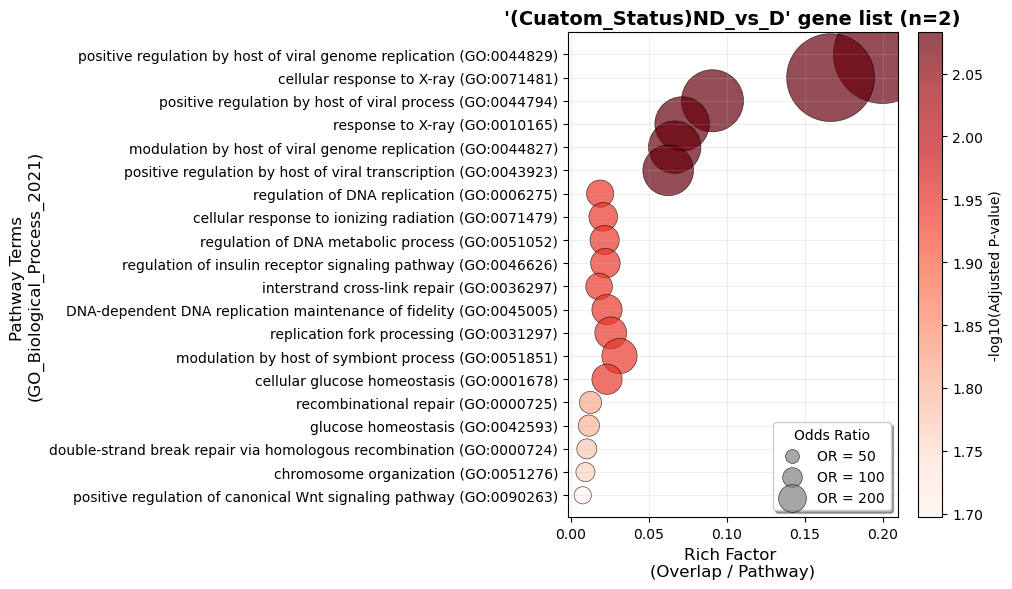

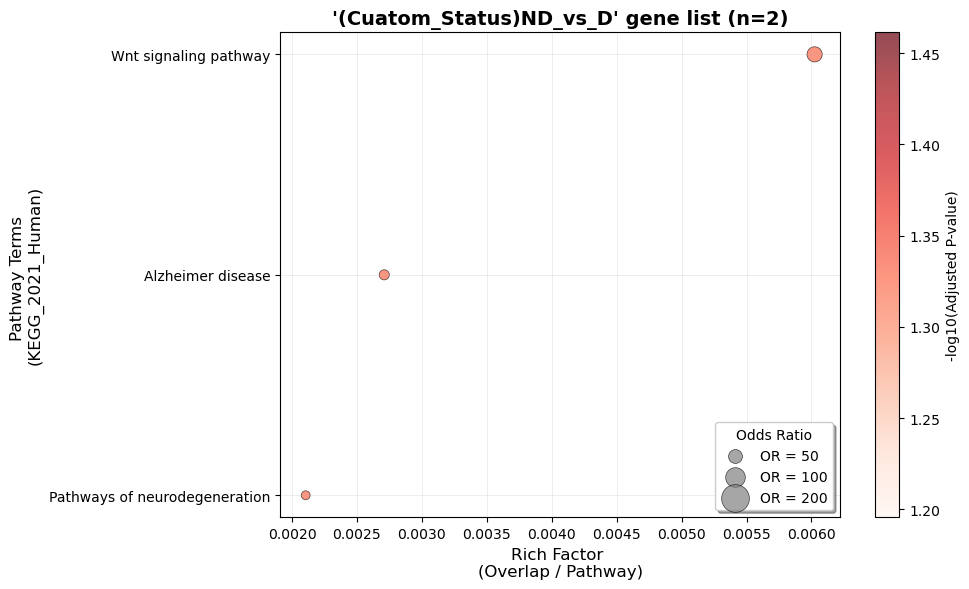

In [102]:
main("MatrixExport_NP_B_Disease.yaml")

In [79]:
main("Imputed_MatrixExport_NP_A.yaml")


Starting enrichment pipeline...
Using clinical variable: Condition

Running enrichment for (Condition)1-C_vs_2-SC...
Filtering out 175/240 samples with irrelevant labels.
Filtered out 174/2142 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_2-SC.

Running enrichment for (Condition)1-C_vs_3-A...
Filtering out 67/240 samples with irrelevant labels.
Filtered out 164/2142 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_3-A.

Running enrichment for (Condition)1-C_vs_4-S...
Filtering out 182/240 samples with irrelevant labels.
Filtered out 166/2142 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition

Starting enrichment pipeline...
Using clinical variable: Condition

Running enrichment for (Condition)1-C_vs_2-SC...
Filtering out 175/240 samples with irrelevant labels.
Filtered out 642/3788 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_2-SC.

Running enrichment for (Condition)1-C_vs_3-A...
Filtering out 67/240 samples with irrelevant labels.
Filtered out 640/3788 proteins with >20% missing values.
Found 7 differentially expressed proteins.
Using 7 mapped genes.
Running enrichment analysis against '['GO_Biological_Process_2021', 'KEGG_2021_Human']'
Saved deg_list to: Imputed_MatrixExport_NP_B\20250722_141215\(Condition)1-C_vs_3-A\(Condition)1-C_vs_3-A_deg_list.txt
Bubble plot saved to: Imputed_MatrixExport_NP_B\20250722_141215\(Condition)1-C_vs_3-A\(Condition)1-C_vs_3-A_GO_Biological_Process_2021_bubble_plot.png
No enriched pathways found for KEGG

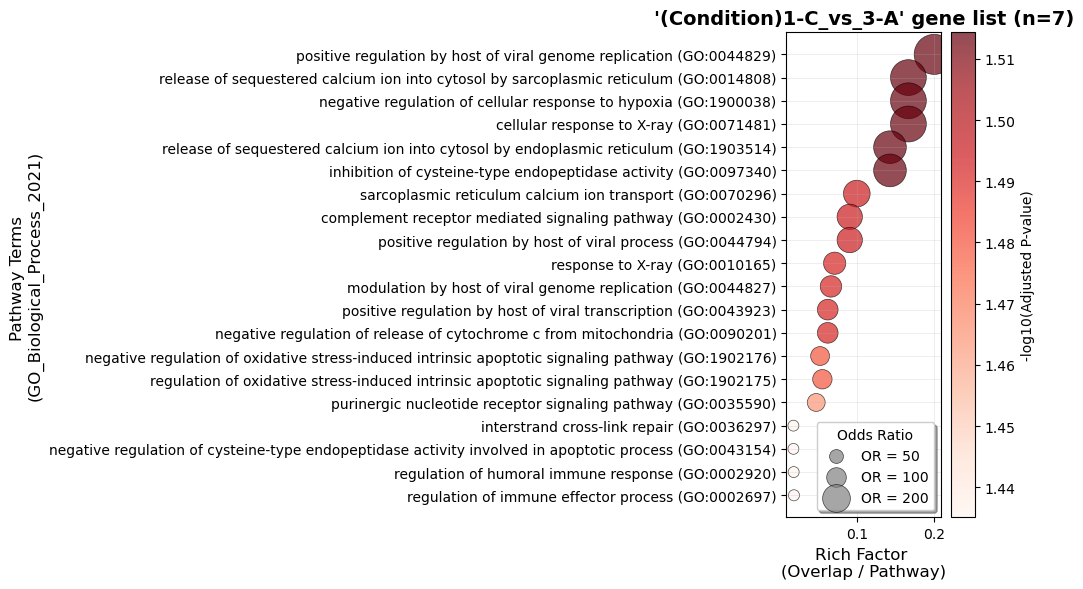

In [80]:
main("Imputed_MatrixExport_NP_B.yaml")

In [81]:
main("MatrixExport_NP_A.yaml")

Starting enrichment pipeline...
Using clinical variable: Condition

Running enrichment for (Condition)1-C_vs_2-SC...
Filtering out 175/240 samples with irrelevant labels.
Filtered out 0/3054 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_2-SC.

Running enrichment for (Condition)1-C_vs_3-A...
Filtering out 67/240 samples with irrelevant labels.
Filtered out 0/3054 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_3-A.

Running enrichment for (Condition)1-C_vs_4-S...
Filtering out 182/240 samples with irrelevant labels.
Filtered out 0/3054 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_v

Starting enrichment pipeline...
Using clinical variable: Condition

Running enrichment for (Condition)1-C_vs_2-SC...
Filtering out 175/240 samples with irrelevant labels.
Filtered out 0/1649 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_2-SC.

Running enrichment for (Condition)1-C_vs_3-A...
Filtering out 67/240 samples with irrelevant labels.
Filtered out 0/1649 proteins with >20% missing values.
Found 7 differentially expressed proteins.
Using 7 mapped genes.
Running enrichment analysis against '['GO_Biological_Process_2021', 'KEGG_2021_Human']'
Saved deg_list to: MatrixExport_NP_B\20250722_141305\(Condition)1-C_vs_3-A\(Condition)1-C_vs_3-A_deg_list.txt
Bubble plot saved to: MatrixExport_NP_B\20250722_141305\(Condition)1-C_vs_3-A\(Condition)1-C_vs_3-A_GO_Biological_Process_2021_bubble_plot.png
No enriched pathways found for KEGG_2021_Human with FDR

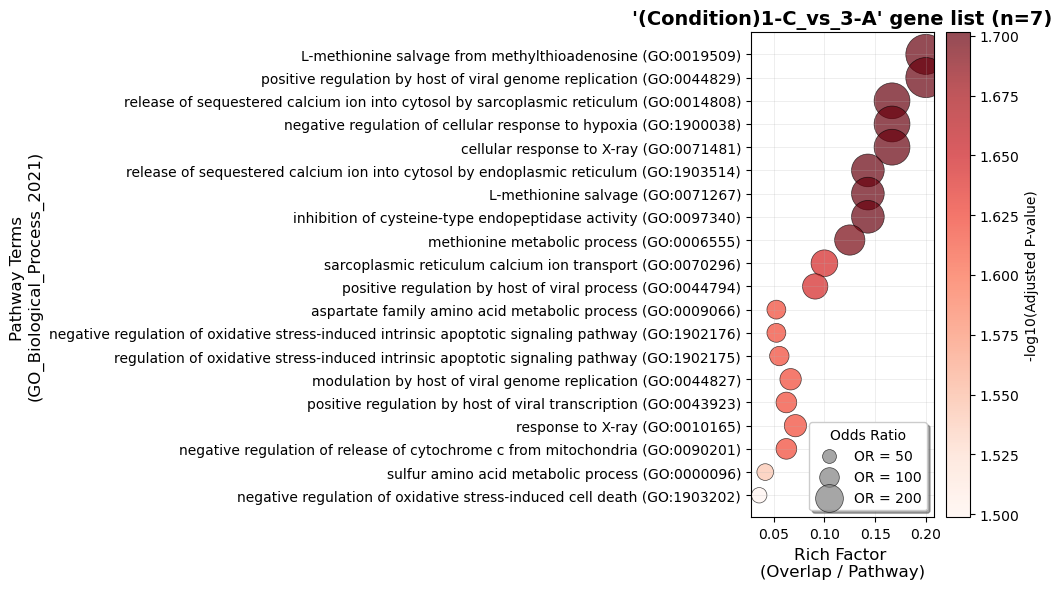

In [82]:
main("MatrixExport_NP_B.yaml")

Starting enrichment pipeline...
Using clinical variable: Condition

Running enrichment for (Condition)1-C_vs_2-SC...
Filtering out 175/240 samples with irrelevant labels.
Filtered out 2353/8320 proteins with >20% missing values.
Found 0 differentially expressed proteins.
Using 0 mapped genes.
No genes identified for enrichment.
No enriched pathways found for (Condition)1-C_vs_2-SC.

Running enrichment for (Condition)1-C_vs_3-A...
Filtering out 67/240 samples with irrelevant labels.
Filtered out 2264/8320 proteins with >20% missing values.
Found 6 differentially expressed proteins.
Using 6 mapped genes.
Running enrichment analysis against '['GO_Biological_Process_2021', 'KEGG_2021_Human']'
Saved deg_list to: original\20250722_141658\(Condition)1-C_vs_3-A\(Condition)1-C_vs_3-A_deg_list.txt
Bubble plot saved to: original\20250722_141658\(Condition)1-C_vs_3-A\(Condition)1-C_vs_3-A_GO_Biological_Process_2021_bubble_plot.png
Bubble plot saved to: original\20250722_141658\(Condition)1-C_vs_3-

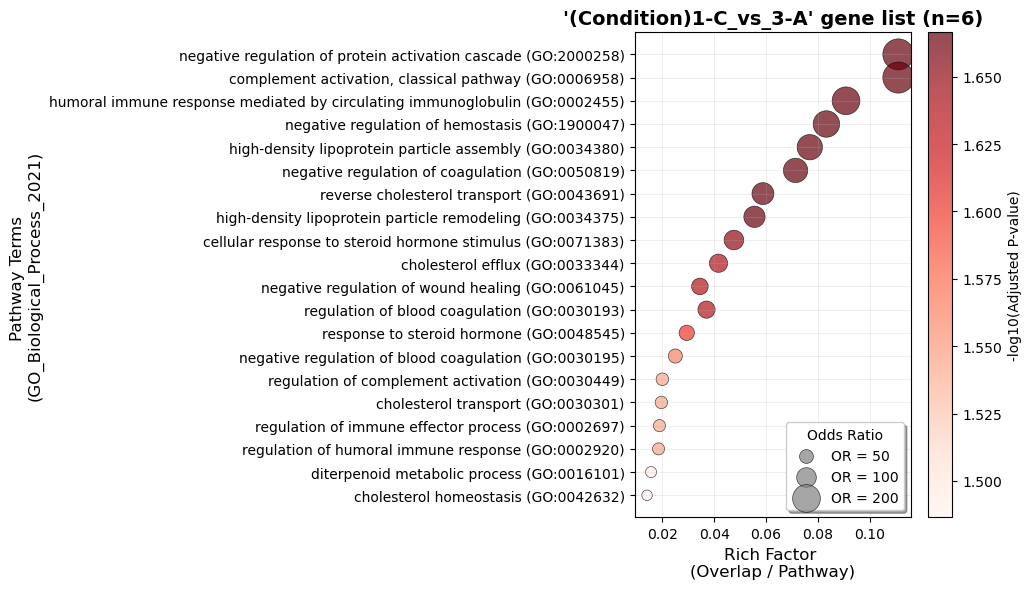

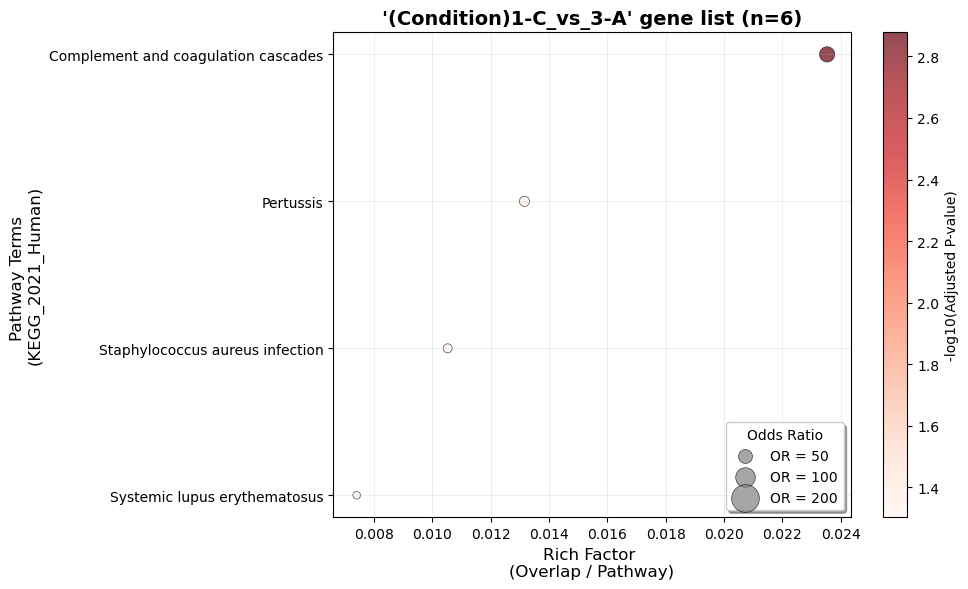

In [83]:
main("original.yaml")


## Debug

In [60]:
from datetime import datetime
config_path = "Imputed_MatrixExport_NP_A.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# Required
protein_group_csv = config["protein_group_csv"]
clinical_csv = config["clinical_csv"]
protgroup_gene_map_json = config["protgroup_gene_map_json"]
var = config["var"]
mapping = config["mapping"]
db = config["db"]
output_dir = config["output_dir"]

In [75]:
    # Optional
    missingness_thresh = config.get("missingness_thresh", 0.2)
    imputation_method = config.get("imputation_method", "mean")
    fdr_thresh = config.get("fdr_thresh", 0.05)

    # Load input files
    protein_group_df = pd.read_csv(protein_group_csv, index_col=0)
    clinical_df = pd.read_csv(clinical_csv, index_col=0)
    with open(protgroup_gene_map_json, 'r') as f:
        protgroup_gene_map = json.load(f)

    print("Starting enrichment pipeline...")
    print("Using clinical variable:", var)

    binary_vars = prepare_categorical_variable_for_pwc(clinical_df, var, fill_value=-1, verbose=False)

    # Create timestamped subdirectory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    timestamped_dir = os.path.join(output_dir, timestamp)
    os.makedirs(timestamped_dir, exist_ok=True)

    #pwc_enr_results = {}
    for pwc, binary_var in binary_vars:
        print()
        print(f"Running enrichment for {pwc}...")
        # Run enrichment
        #pthwys = pathway_enrichment_pipeline(
        enr = pathway_enrichment_pipeline(
            protein_group_df,
            protgroup_gene_map,
            binary_var,
            db,
            missingness_thresh=missingness_thresh,
            imputation_method=imputation_method,
            fdr_thresh=fdr_thresh,
        )

        if enr is None or not hasattr(enr, 'results'):
            print(f"No enriched pathways found for {pwc}.")
            continue

        pthwys = enr.results
        #pwc_enr_results[pwc] = pthwys
    

        pwc_dir = os.path.join(timestamped_dir, pwc)
        os.makedirs(pwc_dir, exist_ok=True)

        deg_list = enr.gene_list

        # Save deg_list as .txt
        out_file = os.path.join(pwc_dir, f"{pwc}_deg_list.txt")
        with open(out_file, 'w') as f:
            for gene in deg_list:
                f.write(f"{gene}\n")
        print(f"Saved deg_list to: {out_file}")
        
        title = f"'{pwc}' gene list (n={len(deg_list)})"
        for db_name in db:
            out_file = os.path.join(pwc_dir, f"{pwc}_{db_name}_bubble_plot.png")
            create_bubble_plot(enr, db_name, x_axis="rich_factor", fdr_thresh=fdr_thresh, title=title, output_path=out_file)

        # Save results
        out_file = os.path.join(pwc_dir, f"{pwc}_enrichment.csv")
        pthwys.to_csv(out_file, index=False)
        print(f"Saved enrichment results to: {out_file}")

    # Save copy of config file
    config_copy_path = os.path.join(timestamped_dir, "config.yaml")
    with open(config_copy_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    print(f"Saved config copy to: {config_copy_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'protein_df_Imputed_MatrixExport_NP_A.csv'

In [62]:
protein_group_df

,3716389,46627359,1681613,3542234,4010630,3812449,46521003,3895058,3476526,3664268,...,4517806,473627584357,3603243,473627329449,3748735,4518542,4207833,3581894,1661502,4535311
T: T: Protein.Group,,,,,,,,,,,,,,,,,,,,,
A0A024R4E5,12.927524,13.246767,12.175166,13.487702,12.908203,11.895969,11.360200,12.570899,12.536956,11.427988,...,11.637426,13.499734,11.421350,9.982509,11.251471,12.199289,11.621374,12.910107,11.565607,11.779276
A0A024R6I7;A0A0G2JRN3,18.629225,13.531942,14.834817,15.818717,19.073864,20.526118,17.091001,15.129102,19.316474,18.320034,...,18.543462,12.300398,16.355871,16.184997,19.298796,18.712581,19.686989,16.309887,19.105174,18.926632
A0A067XG54;A0A804HIW2,14.003087,14.039305,13.758171,13.720736,13.909359,14.482795,15.511929,13.695598,13.968973,14.044078,...,13.965279,14.384561,13.482279,15.533348,14.977521,14.405574,14.101959,13.291502,14.477657,14.718094
A0A075B6H7,20.107893,18.892700,20.001959,18.104624,17.750543,19.602454,19.906284,21.849955,18.550243,17.381011,...,17.907659,19.330383,19.667862,19.874641,19.204719,18.011642,18.289510,19.156202,18.656345,18.566771
A0A075B6H9,13.984766,14.847415,13.916887,13.723864,13.494093,14.304822,16.455515,14.209400,13.235346,12.914815,...,14.484326,14.901352,17.699606,14.527318,14.305335,13.992115,14.822491,17.088529,13.546038,14.037195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P49753,13.994592,13.843185,14.294987,12.766982,14.837051,14.631006,13.606440,13.285865,15.005589,14.955146,...,15.036573,13.952395,14.526970,14.330077,13.980247,15.128321,14.278275,14.732305,15.754449,14.689589
P49754,14.456021,13.590692,14.008700,14.029235,14.311003,13.669793,13.666002,13.601922,14.419407,14.533044,...,14.376783,14.018878,13.837510,13.418933,13.742457,14.218563,13.499821,14.292882,14.166877,13.840021
P49755,18.619149,16.959617,17.840200,18.106747,18.069119,17.454998,16.686035,17.077212,17.936724,18.156197,...,18.407102,17.883526,18.249873,17.159526,18.055521,18.343706,18.144574,18.537969,18.302621,18.322034


In [91]:
protein_group_csv = "protein_group_df.csv"
clinical_csv = "clinical_df.csv"
protgroup_gene_map_json = "protgroup_gene_map.json"

missingness_thresh = 0.2
imputation_method = "mean"
fdr_thresh = 0.05  

db = "KEGG_2021_Human"


# var = "Custom_Active smoker"
# var = "Custom_Hypertension smoker"
# var = "Custom_Ever smoker"
# var = "Custom_Dyslipidemia"
# var = "Custom_DM"
# mapping = {"YES": 1, "NO": 0}


# var = "Custom_Sex"
# mapping = {'M': 1, 'F': 0}

var = "Condition"
mapping = {
    '1-C': 0,
    #'2-SC': 0,
    '3-A': 1,
    '4-S': 1
}

# var = "Diseaseseverity"
# mapping = {
#     'Low': 0,
#     'Mild': 0,
#     'Mild-moderate': 0,
#     'Moderate': 0,
#     'Moderate-severe': 0,
#     'Severe': 1,
# }


In [92]:
clinical_df = pd.read_csv("clinical_df.csv", index_col=0)
protein_group_df = pd.read_csv("protein_group_df.csv", index_col=0)
protgroup_gene_map = json.load(open("protgroup_gene_map.json"))


In [93]:
    binary_var = prepare_categorical_variable(
        clinical_df,
        var=var,
        mapping=mapping)

    dep_list = dep_pipeline(protein_group_df, binary_var, missingness_thresh=missingness_thresh, imputation_method=imputation_method, fdr_thresh=fdr_thresh)
    deg_list = get_deg_list(dep_list, protgroup_gene_map)


Condition values after processing: [-1.0, 0.0, 1.0]
	0: ['1-C']
	1: ['3-A', '4-S']
Filtering out 37/240 samples with irrelevant labels.
Filtered out 2269/8320 proteins with >20% missing values.
Found 2 differentially expressed proteins.
Using 2 mapped genes.


In [94]:
X = filter_features_by_missingness(protein_group_df)
X = impute_missing_values(X, method=imputation_method)
X


Filtered out 2278/8320 proteins with >20% missing values.


,A0A024R4E5,A0A024R6I7;A0A0G2JRN3,A0A067XG54;A0A804HIW2,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,...,Q9Y6U3,Q9Y6V0,Q9Y6W3,Q9Y6W5,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,V9GYE7,V9GYJ8
Sample Name,,,,,,,,,,,,,,,,,,,,,
1171547,3.223473,4.599702,4.539886,4.583185,4.201430,4.557852,4.199298,3.994520,4.857042,4.206087,...,3.963544,4.295875,3.637709,4.144005,3.324891,3.444025,3.648374,5.335976,4.401444,4.737867
1293728,3.447194,3.802972,4.435182,4.432298,4.256502,4.200245,4.174031,3.712423,4.544083,4.012022,...,3.498051,4.183984,3.687932,4.176987,3.975678,3.815025,3.689304,5.262773,4.149881,4.717541
1354335,3.109029,4.150103,4.651963,4.668380,4.056409,4.435465,4.456149,4.204793,4.639626,4.152542,...,3.900024,4.296779,3.774496,4.122292,3.787213,3.577760,3.935054,5.563267,4.111441,5.220491
1529876,3.699543,4.470080,4.648747,4.649616,4.010497,3.905307,4.439933,4.127813,4.990068,4.159352,...,3.873428,4.320454,3.853397,4.339547,4.195095,3.821646,3.415045,5.373434,4.397660,4.597698
1571611,3.785136,5.678896,4.362492,5.061246,4.872729,3.993571,4.314890,4.159325,4.570292,4.002383,...,3.336726,4.091678,3.986103,4.467275,4.378670,4.267123,3.820691,5.080411,4.012736,4.428084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473627545420,3.447698,4.214774,4.458441,5.065181,4.066853,3.926851,4.232220,3.769435,4.526908,4.080028,...,3.722982,4.059736,3.813084,4.325091,4.187608,3.839617,3.861246,5.278037,4.299215,4.750153
473627584286,3.785528,5.761459,4.715582,4.621158,4.413726,4.753044,4.638473,4.200630,4.800504,4.420215,...,3.925515,4.137797,3.991942,4.597105,4.092650,4.125953,3.438122,5.385823,4.265580,4.773798
473627584357,4.024324,3.497897,4.523099,4.888786,4.227338,4.634991,4.448840,4.241713,4.690053,4.291259,...,4.025507,4.136254,4.048959,4.388867,3.962559,4.016360,3.496675,5.339089,4.160171,4.888978


In [33]:
    gene_list = deg_list
    db_name = "GO_Biological_Process_2021"
    dbs = ["GO_Biological_Process_2021", "KEGG_2021_Human"]
    fdr = 0.05
    
    print(f"Running enrichment analysis against '{db_name}' with FDR < {fdr}.")
    enr = gseapy.enrichr(gene_list=gene_list, gene_sets=dbs, organism="human", cutoff=fdr)
    pthwys = enr.results[["Term", "Adjusted P-value", "Odds Ratio"]][enr.results["Adjusted P-value"] < fdr]
    print(f"Found {len(pthwys)} enriched pathways")

Running enrichment analysis against 'GO_Biological_Process_2021' with FDR < 0.05.
Found 11 enriched pathways


In [35]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,"complement activation, classical pathway (GO:0...",1/9,0.000900,0.005499,0,0,2498.750000,17524.581572,C1S
1,GO_Biological_Process_2021,humoral immune response mediated by circulatin...,1/11,0.001100,0.005499,0,0,1998.800000,13617.259335,C1S
2,GO_Biological_Process_2021,regulation of complement activation (GO:0030449),1/50,0.004994,0.010786,0,0,407.122449,2157.568480,C1S
3,GO_Biological_Process_2021,regulation of immune effector process (GO:0002...,1/53,0.005293,0.010786,0,0,383.576923,2010.465718,C1S
4,GO_Biological_Process_2021,regulation of humoral immune response (GO:0002...,1/54,0.005393,0.010786,0,0,376.320755,1965.408658,C1S
5,GO_Biological_Process_2021,regulation of macromolecule metabolic process ...,1/200,0.019900,0.033167,0,0,99.492462,389.713783,ZNF462
6,GO_Biological_Process_2021,positive regulation of transcription by RNA po...,1/908,0.088741,0.126772,0,0,21.048512,50.980261,ZNF462
7,GO_Biological_Process_2021,regulation of gene expression (GO:0010468),1/1079,0.104992,0.127560,0,0,17.551020,39.557797,ZNF462
8,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",1/1183,0.114804,0.127560,0,0,15.918782,34.456698,ZNF462
9,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,1/2206,0.208438,0.208438,0,0,8.069388,12.653699,ZNF462


In [31]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,"complement activation, classical pathway (GO:0...",1/9,0.000900,0.005499,0,0,2498.750000,17524.581572,C1S
1,GO_Biological_Process_2021,humoral immune response mediated by circulatin...,1/11,0.001100,0.005499,0,0,1998.800000,13617.259335,C1S
2,GO_Biological_Process_2021,regulation of complement activation (GO:0030449),1/50,0.004994,0.010786,0,0,407.122449,2157.568480,C1S
3,GO_Biological_Process_2021,regulation of immune effector process (GO:0002...,1/53,0.005293,0.010786,0,0,383.576923,2010.465718,C1S
4,GO_Biological_Process_2021,regulation of humoral immune response (GO:0002...,1/54,0.005393,0.010786,0,0,376.320755,1965.408658,C1S
5,GO_Biological_Process_2021,regulation of macromolecule metabolic process ...,1/200,0.019900,0.033167,0,0,99.492462,389.713783,ZNF462
6,GO_Biological_Process_2021,positive regulation of transcription by RNA po...,1/908,0.088741,0.126772,0,0,21.048512,50.980261,ZNF462
7,GO_Biological_Process_2021,regulation of gene expression (GO:0010468),1/1079,0.104992,0.127560,0,0,17.551020,39.557797,ZNF462
8,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",1/1183,0.114804,0.127560,0,0,15.918782,34.456698,ZNF462
9,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,1/2206,0.208438,0.208438,0,0,8.069388,12.653699,ZNF462


In [32]:
vars(enr)

{'gene_list': ['C1S', 'ZNF462'],
 'gene_sets': 'GO_Biological_Process_2021',
 'descriptions': '',
 'outdir': None,
 'cutoff': 0.05,
 'format': 'pdf',
 'figsize': (6.5, 6),
 '_Enrichr__top_term': 10,
 '_Enrichr__no_plot': False,
 'verbose': False,
 'module': 'enrichr',
 'res2d':                      Gene_set  \
 0  GO_Biological_Process_2021   
 1  GO_Biological_Process_2021   
 2  GO_Biological_Process_2021   
 3  GO_Biological_Process_2021   
 4  GO_Biological_Process_2021   
 5  GO_Biological_Process_2021   
 6  GO_Biological_Process_2021   
 7  GO_Biological_Process_2021   
 8  GO_Biological_Process_2021   
 9  GO_Biological_Process_2021   
 
                                                 Term Overlap   P-value  \
 0  complement activation, classical pathway (GO:0...     1/9  0.000900   
 1  humoral immune response mediated by circulatin...    1/11  0.001100   
 2   regulation of complement activation (GO:0030449)    1/50  0.004994   
 3  regulation of immune effector process (GO: